In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

candidates = pd.read_csv('candidates.csv')
candidates.columns

Index(['Candidate Name', 'Riding', 'Party', 'Votes Count', 'Votes Percent',
       'Elected', 'Win Margin Count', 'Win Margin Percent'],
      dtype='object')

In [222]:
plt.rc('font',family='Noto Sans', size=14)

def partyColour(partyList):
    lookup = {'PCP': '#2B328C', 'NDP': '#FF4C00', 'LIB': '#E3102B', 'GPO': '#307730'}
    return [lookup[party] for party in partyList]

def plotBarStyled(x):
    plt.figure(figsize=(8.5,6)) 
    
    ax = x.plot.bar(color=partyColour(x.index))
    
    ymax = plt.ylim()[1]
    unit = ymax/72
    
    ax.yaxis.set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        if (p.get_height() > 8*unit):
            y_pos = p.get_height() - 4*unit
            col = 'white'
        else:
            y_pos = p.get_height() + unit
            col = 'black'
        ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, y_pos), ha='center',
                    size=16, weight=600, color=col)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    
    return ax

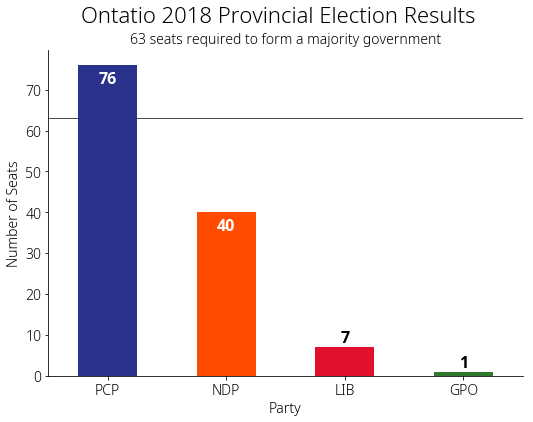

In [231]:
# What were the election counts
x = candidates.loc[candidates['Elected'], 'Party'].value_counts()
 
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election Results', size=22)
plt.title('63 seats required to form a majority government', size=14)

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)


Text(0.5,1,'Ontario 2018 Provincial Election')

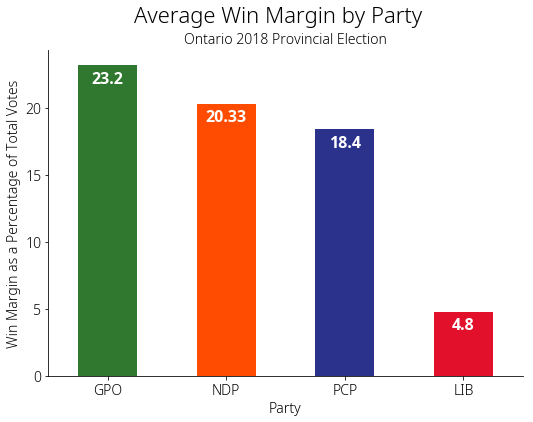

In [242]:
x = candidates.groupby('Party')['Win Margin Percent'].mean().dropna().round(2).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Win Margin as a Percentage of Total Votes')
plt.suptitle('Average Win Margin by Party', size=22)
plt.title('Ontario 2018 Provincial Election', size=14)

## Did the Green Party help the Progressive Conservative Party by splitting votes from the NDP?

In [244]:
#runners_up_indicies = candidates.loc[candidates['Elected'] == False].groupby('Riding')['Votes Count'].idxmax()
#runners_up = candidates.loc[runners_up_indicies].set_index('Riding')
#green_candidates = candidates.loc[candidates['Party'] == 'GPO'].set_index('Riding')
#winners = candidates.loc[candidates['Elected']].set_index('Riding')
runners_up = (candidates.loc[candidates['Elected'] == False]
              .sort_values('Votes Count', ascending=False)
              .drop_duplicates('Riding')
              .set_index('Riding')
              .sort_index())
green_candidates = candidates.loc[candidates['Party'] == 'GPO'].set_index('Riding')
winners = candidates.loc[candidates['Elected']].set_index('Riding')

In [245]:
# Candidates that would have lost had Green Party votes gone to the runner-up
diff_indicies = winners['Win Margin Count'].sub(green_candidates['Votes Count']) < 0
winners.loc[diff_indicies & (winners['Party'] == 'PCP')]

,Candidate Name,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Riding,,,,,,,
Brampton West,Amarjot Sandhu,PCP,14951,39.4,True,490.0,1.3
Brantford—Brant,Willem Bouma,PCP,24437,42.0,True,635.0,1.1
Cambridge,Belinda Karahalios,PCP,17793,37.0,True,2154.0,4.5
Eglinton—Lawrence,Robin Martin,PCP,19999,40.4,True,957.0,1.9
Kitchener—Conestoga,Michael Harris,PCP,17005,39.6,True,686.0,1.6
Kitchener South—Hespeler,Amy Fee,PCP,16511,38.9,True,770.0,1.8
Ottawa West—Nepean,Jeremy Roberts,PCP,16590,32.8,True,175.0,0.3
Sault Ste. Marie,Rosario Romano,PCP,13498,42.0,True,414.0,1.3
Scarborough—Rouge Park,Vijayadhithyan Thanigasalam,PCP,16224,38.6,True,963.0,2.3


In [246]:
PCP_ridings = candidates.loc[(candidates['Party'] == 'PCP') & candidates['Elected'], 'Riding'].values
if_no_green_votes = pd.Series(runners_up.loc[(winners['Party'] == 'PCP'), 'Votes Count'].add(green_candidates['Votes Count']).values, index=runners_up['Candidate Name'], name='Votes Count')

candidates_no_green = candidates.copy().set_index('Candidate Name')
candidates_no_green.update(if_no_green_votes)
# Drop GPO candidate rows in PCP ridings
candidates_no_green = candidates_no_green[
    (~candidates_no_green['Riding'].isin(PCP_ridings)) |
    (candidates_no_green['Party'] != 'GPO')]

candidates_no_green.loc[candidates_no_green.groupby('Riding')['Votes Count'].idxmax(), 'Party'].value_counts()

PCP    67
NDP    48
LIB     8
GPO     1
Name: Party, dtype: int64

In [252]:
new_winners = candidates_no_green.sort_values('Votes Count', ascending=False).drop_duplicates('Riding')
new_winners.loc[new_winners['Elected'] == False]

,Riding,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Candidate Name,,,,,,,
Alexandra Felsky,Brantford—Brant,NDP,26543.0,40.9,False,NaN,NaN
Michael Colle,Eglinton—Lawrence,LIB,20232.0,38.4,False,NaN,NaN
Kelly Dick,Kitchener—Conestoga,NDP,19172.0,38.0,False,NaN,NaN
Fitzroy Vanderpool,Kitchener South—Hespeler,NDP,18939.0,37.1,False,NaN,NaN
Marjorie Knight,Cambridge,NDP,18657.0,32.5,False,NaN,NaN
Chandra Pasma,Ottawa West—Nepean,NDP,18352.0,32.5,False,NaN,NaN
Felicia Samuel,Scarborough—Rouge Park,NDP,16275.0,36.3,False,NaN,NaN
Jagroop Pangli,Brampton West,NDP,15460.0,38.1,False,NaN,NaN
Michele McCleave-Kennedy,Sault Ste. Marie,NDP,14128.0,40.7,False,NaN,NaN


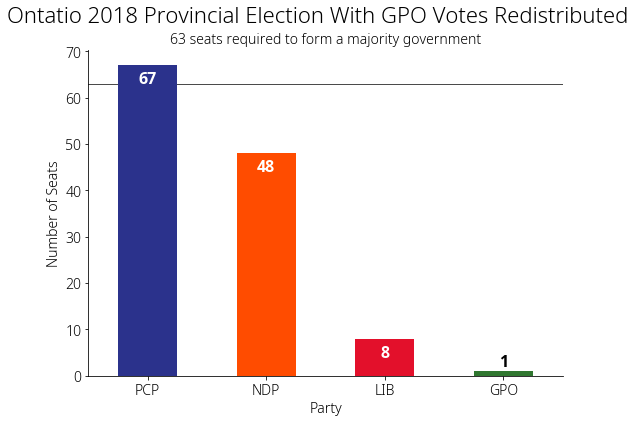

In [251]:
x = new_winners['Party'].value_counts()
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election With GPO Votes Redistributed', size=22)
plt.title('63 seats required to form a majority government', size=14)

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)

# Census Data

In [257]:
census = candidates.set_index('Riding').join(pd.read_csv('formatted_census_data.csv', index_col=0))

def w_mean (df, col):
    parties = ['GPO', 'LIB', 'NDP', 'PCP']
    g = df.loc[df['Party'].isin(parties)].assign(w_means=lambda x: x[col] * x['Votes Count']).groupby('Party')
    return (g['w_means'].sum() / g['Votes Count'].sum()).rename(col)

census.columns

Index(['Candidate Name', 'Party', 'Votes Count', 'Votes Percent', 'Elected',
       'Win Margin Count', 'Win Margin Percent', '2016 Population',
       'Pop. % 0-19', 'Pop. % 20-39', 'Pop. % 40-59', 'Pop. % 60-79',
       'Pop. % 80-', 'Pop Density (km^2)', '% Male', '% Married/Common Law',
       '% Divorced', '% Lone Parent', '% Immigrant', 'Household Med. Income',
       '1p Household Med. Income', '2+p Household Med. Income'],
      dtype='object')

In [278]:
pop_columns = ['Pop. % 20-39', 'Pop. % 40-59', 'Pop. % 60-79', 'Pop. % 80-']
pd.concat([census.pipe(w_mean, pop) for pop in pop_columns], axis=1).iloc[2]

sns.distplot(census.loc['% Immigrant'])

<function seaborn.distributions.distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)>

In [258]:
census.pipe(w_mean, '% Immigrant')

Party
GPO    23.302976
LIB    31.261254
NDP    26.121426
PCP    26.920306
Name: % Immigrant, dtype: float64

In [256]:
pd.concat([
    census.pipe(w_mean, 'Pop. % 20-39'),
    census.pipe(w_mean, 'Pop. % 40-59'),
    census.pipe(w_mean, 'Pop. % 60-79'),
    census.pipe(w_mean, 'Pop. % 80-')], axis=1).T

Party,GPO,LIB,NDP,PCP
Pop. % 20-39,25.526845,26.262863,26.178222,24.609764
Pop. % 40-59,28.470109,28.556331,28.060490,28.760415
Pop. % 60-79,18.852750,18.244917,18.462524,19.109410
Pop. % 80-,4.461575,4.440161,4.378945,4.470490


In [38]:
census.pipe(w_mean, '% Male')

Party
GPO    48.638287
LIB    48.387096
NDP    48.196084
PCP    48.576531
Name: % Male, dtype: float64

In [39]:
census.pipe(w_mean, 'Pop Density (km^2)')

Party
GPO    1534.858696
LIB    2300.887944
NDP    2112.165843
PCP    1456.767072
Name: Pop Density (km^2), dtype: float64

In [45]:
pd.concat([census.pipe(w_mean, 'Household Med. Income'),
           census.pipe(w_mean, '1p Household Med. Income'),
           census.pipe(w_mean, '2+p Household Med. Income')],  axis=1)

,Household Med. Income,1p Household Med. Income,2+p Household Med. Income
Party,,,
GPO,77132.068126,38605.428659,93128.499325
LIB,78201.290230,39909.655266,94448.942112
NDP,73818.156970,37676.245901,90123.170346
PCP,78591.217290,38707.987314,93319.512950


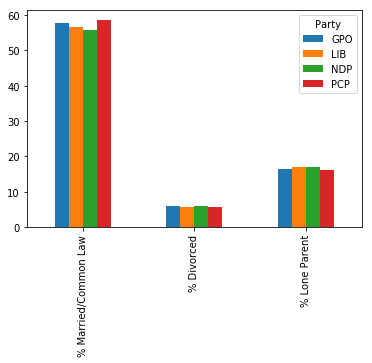

In [48]:
pd.concat([census.pipe(w_mean, col) for col in ['% Married/Common Law', '% Divorced', '% Lone Parent']], axis=1).T.plot.bar()

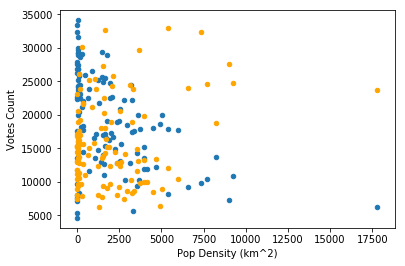

In [111]:
#census.loc[census['Party'] == 'PCP'].sort_values('Pop Density (km^2)')['Votes Count'].plot.line()
ax = census.loc[(census['Party'] == 'PCP')].plot.scatter(x='Pop Density (km^2)', y='Votes Count')
census.loc[(census['Party'] == 'NDP')].plot.scatter(x='Pop Density (km^2)', y='Votes Count', color='orange', ax=ax)

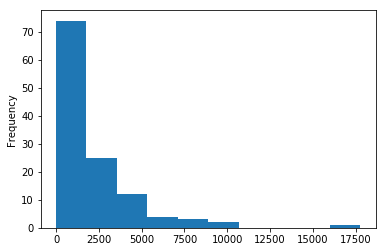

In [15]:
census.loc[census['Elected'], 'Pop Density (km^2)'].sort_values().plot.hist()

,Candidate Name,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent,2016 Population,Pop. % 0-19,Pop. % 20-39,...,Pop. % 80-,Pop Density (km^2),% Male,% Married/Common Law,% Divorced,% Lone Parent,% Immigrant,Household Med. Income,1p Household Med. Income,2+p Household Med. Income
Ajax,Rodney Phillips,PCP,19078,39.0,True,3948.0,8.1,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Monique Hughes,NDP,15130,31.0,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Louis Dickson,LIB,12607,25.8,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Stephen Leahy,GPO,1224,2.5,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Marsha Haynes,LTN,312,0.6,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Frank Lopez,NAP,289,0.6,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Ajax,Kevin Brackley,IND,220,0.5,False,NaN,NaN,119677.0,26.90,26.81,...,2.36,1786.4,48.35,58.36,4.86,19.02,38.88,96949.0,46407.0,106803.0
Algoma—Manitoulin,Michael Mantha,NDP,17105,58.6,True,9962.0,34.1,79483.0,19.61,18.28,...,5.38,0.9,49.88,61.50,5.40,15.17,4.39,56626.0,26661.0,74193.0
Algoma—Manitoulin,Byron Turner,PCP,7143,24.5,False,NaN,NaN,79483.0,19.61,18.28,...,5.38,0.9,49.88,61.50,5.40,15.17,4.39,56626.0,26661.0,74193.0
Algoma—Manitoulin,Charles Fox,LIB,2365,8.1,False,NaN,NaN,79483.0,19.61,18.28,...,5.38,0.9,49.88,61.50,5.40,15.17,4.39,56626.0,26661.0,74193.0


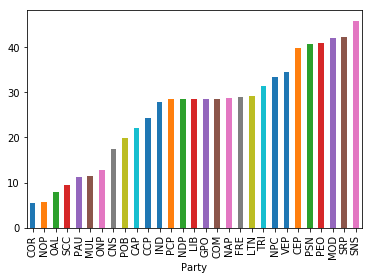

In [18]:
census.groupby('Party')['% Immigrant'].mean().sort_values().plot.bar()
census

# ToDo
Visualizations
Write Post

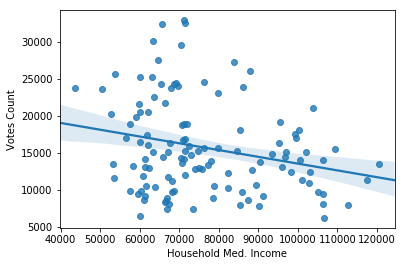

In [82]:
import seaborn as sns
df = census.loc[census['Party'] == 'NDP']
sns.regplot(df['Household Med. Income'], df['Votes Count'])

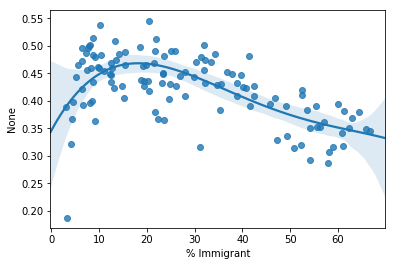

In [81]:
df = census.groupby(census.index)
sns.regplot(df['% Immigrant'].first(), df['Votes Count'].sum() / df['2016 Population'].first(), order=4)